## CSC4160: Cloud Computing Final Project

Modern cloud platforms require users to specify CPU and memory before a job starts. <br> However, these requests are frequently inaccurate. This leads to: <br>
Overallocation → low utilization, wasted cost <br>
Underallocation → OOM kills, retries, SLA violations <br>
Unpredictable behavior → schedulers forced to be conservative <br><br>
Understanding and predicting actual job behavior is critical to improving efficiency in data centers.

In [100]:
# Import necessary libraries for data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### **Google Cluster Trace 2019 Dataset**

The **Google Cluster Trace 2019** dataset is a large, publicly released dataset containing detailed logs from Google’s production data centers.  
It records how real workloads were scheduled, executed, and monitored across thousands of machines.

Some details include:
- CPU and memory usage sampled every few seconds  
- User-requested resources (how much CPU/memory jobs asked for)  
- Per-task and per-collection event histories  
- Task failures, evictions, and vertical scaling events  

This dataset from Google's data center provides a realistic foundation for studying workload behavior, resource inefficiency, and scheduling patterns in modern cloud systems.  

---

### **Google BigQuery**

**Google BigQuery** is a serverless, cloud-based data warehouse designed for interactive queries over extremely large datasets (TB–PB scale).  
The Google Cluster Trace is stored natively in BigQuery because the raw logs are massive—far too large for normal machines to process.

The raw Google Cluster Trace is not a ready-to-use CSV file.  
It is spread across **multiple tables**, each describing different aspects of workload execution:
- `instance_usage` → runtime CPU and memory usage  
- `instance_events` → lifecycle events (start, finish, fail, evict)  
- `collection_events` → job-level metadata  

To build a meaningful dataset for machine learning, we can join and filter these tables. BigQuery enables us to extract a combined dataset from the very large Google Cluster Trace 2019 logs.  
The SQL code to generate the dataset is found at *BigQuerySQL.txt*.


In [101]:
CSV_PATH = "GoogleCloudTrace2019.csv"

In [102]:
df = pd.read_csv(CSV_PATH)

df.head()   # Display the first few rows of the dataframe

,collection_id,instance_index,machine_id,start_time,end_time,avg_cpus,avg_memory,max_cpus,max_memory,assigned_memory,page_cache_memory,cycles_per_instruction,memory_accesses_per_instruction,sample_rate,cpu_usage_distribution_json,tail_cpu_usage_distribution_json,instance_events_json,collection_events_json
0,360940137080,231,224032080418,64626000000,64627000000,0.000000,1.907349e-06,0.000000,1.907349e-06,0.0,0.000173,0.620937,0.001780,1.000000,"[0,0,0,0,0,0,0,0,0,0,0]","[0,0,0,0,0,0,0,0,0]","[{""time"":60013249940,""type"":3,""collection_id"":...","[{""time"":0,""type"":2,""collection_id"":3609401370..."
1,360940137080,1272,102892529513,2520000000000,2520300000000,0.008026,6.271362e-03,0.094360,9.826660e-03,0.0,0.001297,1.315691,0.006137,0.993333,"[0.0001239776611328125,0.00044345855712890625,...","[0.017425537109375,0.01788330078125,0.01889038...","[{""time"":2510406957821,""type"":2,""collection_id...","[{""time"":0,""type"":2,""collection_id"":3609401370..."
2,360940137080,1316,573424754,1980600000000,1980900000000,0.014206,6.965637e-03,0.062256,9.689331e-03,0.0,0.000706,2.214612,0.010292,1.000000,"[5.435943603515625e-05,0.00043582916259765625,...","[0.035888671875,0.03692626953125,0.03723144531...","[{""time"":1978725502295,""type"":3,""collection_id...","[{""time"":0,""type"":2,""collection_id"":3609401370..."
3,360940137080,174,23624515492,1568096000000,1568100000000,0.001070,3.623962e-05,0.001883,7.152557e-05,0.0,0.000033,NaN,NaN,1.000000,"[2.09808349609375e-05,2.09808349609375e-05,0.0...","[0.0018825531005859375,0.0018825531005859375,0...","[{""time"":1568086963555,""type"":3,""collection_id...","[{""time"":0,""type"":2,""collection_id"":3609401370..."
4,360940137080,194,23744499476,1289870000000,1289872000000,0.000169,9.536743e-07,0.000289,9.536743e-07,0.0,0.000664,0.927320,0.004282,1.000000,"[0,0,0,0,0,0.00014400482177734375,0.0002870559...","[0.00028705596923828125,0.00028705596923828125...","[{""time"":1288840405334,""type"":3,""collection_id...","[{""time"":0,""type"":2,""collection_id"":3609401370..."


In [103]:
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())

print("\nDtypes:")
print(df.dtypes)

Shape: (90000, 18)

Columns: ['collection_id', 'instance_index', 'machine_id', 'start_time', 'end_time', 'avg_cpus', 'avg_memory', 'max_cpus', 'max_memory', 'assigned_memory', 'page_cache_memory', 'cycles_per_instruction', 'memory_accesses_per_instruction', 'sample_rate', 'cpu_usage_distribution_json', 'tail_cpu_usage_distribution_json', 'instance_events_json', 'collection_events_json']

Dtypes:
collection_id                         int64
instance_index                        int64
machine_id                            int64
start_time                            int64
end_time                              int64
avg_cpus                            float64
avg_memory                          float64
max_cpus                            float64
max_memory                          float64
assigned_memory                     float64
page_cache_memory                   float64
cycles_per_instruction              float64
memory_accesses_per_instruction     float64
sample_rate                  

In [104]:
df["cpu_usage_distribution_json"][1]

'[0.0001239776611328125,0.00044345855712890625,0.000522613525390625,0.00072383880615234375,0.0010433197021484375,0.00567626953125,0.0093231201171875,0.0105743408203125,0.012664794921875,0.0169677734375,0.039306640625]'

`cpu_usage_distribution_json`: 
This column contains a JSON-encoded list representing the CPU usage histogram for the container instance.  
Each value corresponds to the *fraction of total execution time* spent in a particular CPU-usage bin (e.g., 0-10%, 10-20% ...... ,80-90%, 90-100%).  

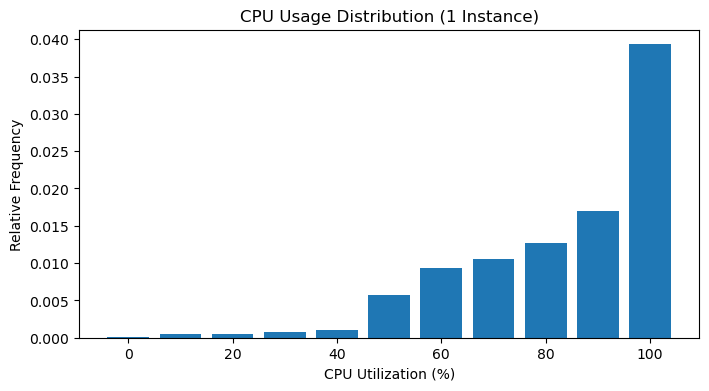

In [105]:
# Visualize CPU Usage Distribution for an Example Instance (Histogram)

import json

instance = json.loads(df["cpu_usage_distribution_json"].iloc[1])

# Define bins (approximate 0–100% CPU utilization)
bins = np.linspace(0, 100, len(instance))

plt.figure(figsize=(8,4))
plt.bar(bins, instance, width=8)
plt.xlabel("CPU Utilization (%)")
plt.ylabel("Relative Frequency")
plt.title("CPU Usage Distribution (1 Instance)")
plt.show()


**CPU Usage Distribution Plot (Interpretation):**  
This histogram visualizes the `cpu_usage_distribution_json` field for a single container instance.  
The distribution shows how the workload actually consumed CPU cycles over its lifetime, revealing whether the task was mostly idle, moderately active, or highly CPU-intensive.  
This information is only available *after* the job runs and therefore is not visible to the scheduler, but it is useful for workload characterization and analyzing usage patterns.


In [106]:
# Compute Average CPU Usage Distribution Across All Instances

parsed = [
    json.loads(x)
    for x in df["cpu_usage_distribution_json"].dropna()
]

# Ensure all histograms have equal length
max_len = max(len(p) for p in parsed)
parsed = [p + [0]*(max_len - len(p)) for p in parsed]

# Stack and average across all instances
hist_array = np.array(parsed)
mean_hist = np.mean(hist_array, axis=0)


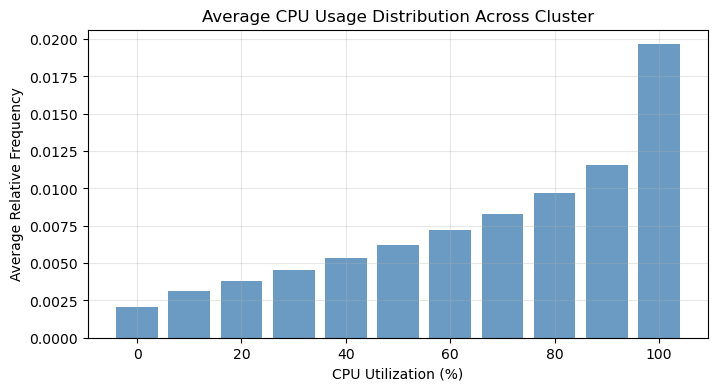

In [107]:
bins = np.linspace(0, 100, len(mean_hist))

plt.figure(figsize=(8,4))
plt.bar(bins, mean_hist, width=8, color='steelblue', alpha=0.8)
plt.xlabel("CPU Utilization (%)")
plt.ylabel("Average Relative Frequency")
plt.title("Average CPU Usage Distribution Across Cluster")
plt.grid(alpha=0.3)
plt.show()


**Average CPU Usage Distribution Across the Cluster:**  
This chart aggregates the `cpu_usage_distribution_json` histograms from all container instances and plots the *mean relative frequency* for each CPU-utilization bin.  
Each bar reflects how much time, on average, workloads across the cluster spend in specific CPU usage ranges (e.g., 0–10%, 10–20%, …, 90–100%).  

The distribution shows that CPU usage generally increases toward the higher bins, meaning many workloads exhibit bursts or sustained periods of high CPU consumption.  
This cluster-wide view helps identify global workload patterns, system pressure, and overall CPU behavior, but—like the per-instance distributions—is only available after execution and is not visible to the scheduler in real time.


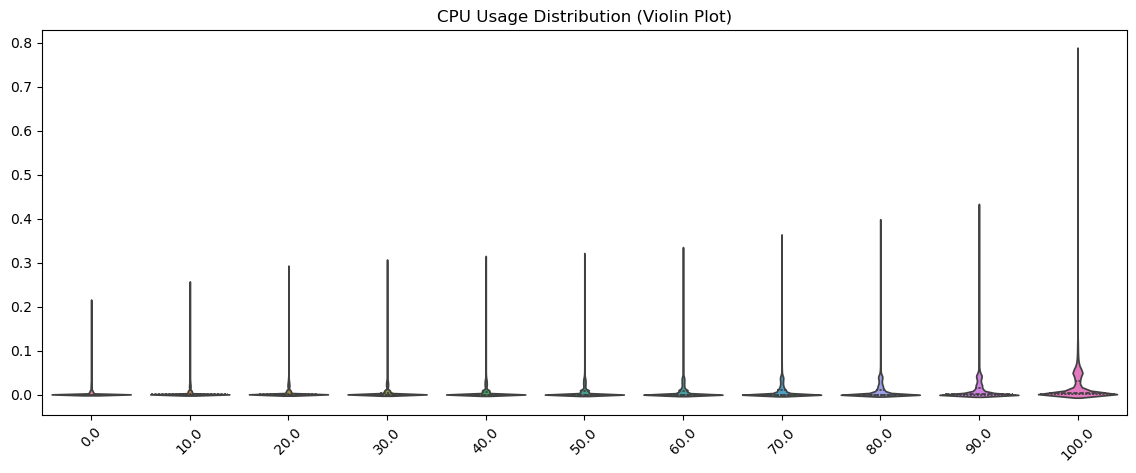

In [108]:
# Convert to DataFrame for heatmap
hist_df = pd.DataFrame(hist_array, columns=bins)

plt.figure(figsize=(14,5))
sns.violinplot(data=hist_df, inner="quartile")
plt.xticks(rotation=45)
plt.title("CPU Usage Distribution (Violin Plot)")
plt.show()


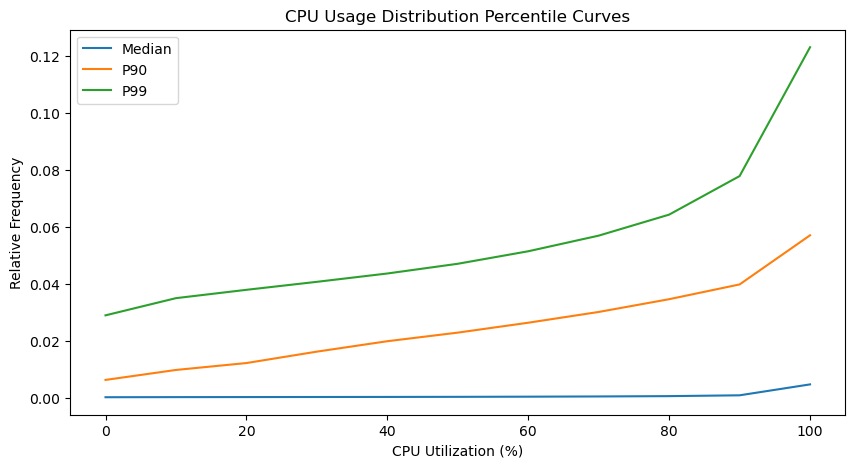

In [109]:
p50 = np.percentile(hist_array, 50, axis=0)
p90 = np.percentile(hist_array, 90, axis=0)
p99 = np.percentile(hist_array, 99, axis=0)

plt.figure(figsize=(10,5))
plt.plot(bins, p50, label="Median")
plt.plot(bins, p90, label="P90")
plt.plot(bins, p99, label="P99")
plt.legend()
plt.title("CPU Usage Distribution Percentile Curves")
plt.xlabel("CPU Utilization (%)")
plt.ylabel("Relative Frequency")
plt.show()


This violin plot shows the *distribution shape* of CPU usage values for each bin.
Wider areas indicate more instances with usage in that range.
It highlights variability, multimodal patterns, and how different workloads behave inside each bin.


This percentile plot summarizes CPU usage using p50, p90, p95, and p99 values.
It shows typical behavior (median) as well as how extreme or bursty workloads can be.
Useful for understanding upper-tail CPU demand patterns.


In [110]:
df["collection_events_json"][1]

'[{"time":0,"type":2,"collection_id":360940137080,"scheduling_class":2,"missing_type":null,"collection_type":0,"priority":360,"alloc_collection_id":330587162970,"user":"DrrEIEWkWuW7RrZwpHLCN0k0A2J0usJeyt3wtqzZ7Kk=","collection_name":"myqRrKor4KVGEA9s99pmSbf4odjAvSrKCa+6qLdhRJM=","collection_logical_name":"wcRcAMuop2OqH9EW4feH919tadFec5a11ply0hcS/C8=","parent_collection_id":null,"start_after_collection_ids":[],"max_per_machine":null,"max_per_switch":null,"vertical_scaling":2,"scheduler":0},{"time":0,"type":0,"collection_id":360940137080,"scheduling_class":2,"missing_type":null,"collection_type":0,"priority":360,"alloc_collection_id":330587162970,"user":"DrrEIEWkWuW7RrZwpHLCN0k0A2J0usJeyt3wtqzZ7Kk=","collection_name":"myqRrKor4KVGEA9s99pmSbf4odjAvSrKCa+6qLdhRJM=","collection_logical_name":"wcRcAMuop2OqH9EW4feH919tadFec5a11ply0hcS/C8=","parent_collection_id":null,"start_after_collection_ids":[],"max_per_machine":null,"max_per_switch":null,"vertical_scaling":2,"scheduler":0},{"time":0,"typ

In [111]:
df["instance_events_json"][1]

'[{"time":2510406957821,"type":2,"collection_id":360940137080,"scheduling_class":2,"missing_type":null,"collection_type":0,"priority":360,"alloc_collection_id":330587162970,"instance_index":1272,"machine_id":102892529513,"alloc_instance_index":null,"resource_request":{"cpus":0.0091705322265625,"memory":0.0013027191162109375},"constraint":[]},{"time":2511047153988,"type":0,"collection_id":360940137080,"scheduling_class":2,"missing_type":null,"collection_type":0,"priority":360,"alloc_collection_id":330587162970,"instance_index":1272,"machine_id":102892529513,"alloc_instance_index":null,"resource_request":{"cpus":0.0091705322265625,"memory":0.0013027191162109375},"constraint":[]},{"time":2528621425997,"type":3,"collection_id":360940137080,"scheduling_class":2,"missing_type":null,"collection_type":0,"priority":360,"alloc_collection_id":330587162970,"instance_index":1272,"machine_id":102892529513,"alloc_instance_index":null,"resource_request":{"cpus":0.0091705322265625,"memory":0.0013027191

### Instance Events JSON Format
Each row contains a JSON array of **instance-level lifecycle events**.  
Every object describes a single event emitted while a task was running on a machine, including:

- `time` — timestamp of the event  
- `type` — event type (e.g., start, finish, fail, evict)  
- `machine_id` — the machine where the instance was scheduled  
- `resource_request` — CPU and memory requested by the container  
- `constraint` — placement constraints (usually empty)

The instance events log the *actual execution timeline* of a container and provide information on failures, evictions, rescheduling, and re-allocations.

### Collection Events JSON Format
Each row contains a JSON array of **collection-level events**, describing metadata for the whole job (collection) that the instance belongs to, including:

- `collection_name` and `collection_logical_name`  
- `scheduling_class` and `priority`  
- `vertical_scaling` and scheduler ID  
- `start_after_collection_ids` — dependency lists

These events describe how the job was defined and submitted, not how it executed.

### What the Output Represents
Together, `instance_events_json` and `collection_events_json` provide:

- The **job’s metadata** (collection events)  
- The **task’s execution history** (instance events)  
- All necessary signals for extracting failures, start/stop times, rescheduling behavior, and resource request patterns.

These JSON fields must be parsed and expanded before feature engineering or modeling can begin.


In [112]:
import json
import numpy as np
import pandas as pd

# ---------- 1) INSTANCE EVENTS ----------

def parse_instance_events(events_json_str):
    """
    Parse instance_events_json and return a dict of columns:
      - event_time (time of last event)
      - instance_events_type (last event type)
      - scheduling_class, collection_type, priority, alloc_collection_id,
        instance_index, machine_id
      - resource_request_cpus, resource_request_memory
      - constraint (stringified)
      - failed (1 if last event type == 4, else 0)
    """
    if pd.isna(events_json_str):
        return {}

    try:
        events = json.loads(events_json_str)
    except json.JSONDecodeError:
        return {}

    if not events:
        return {}

    # helper: safely get time as int
    def get_time(e):
        t = e.get("time", 0)
        try:
            return int(t)
        except (TypeError, ValueError):
            return 0

    # choose the last event by numeric time
    last_event = max(events, key=get_time)

    res_req = last_event.get("resource_request") or {}

    return {
        "event_time": get_time(last_event),
        "instance_events_type": last_event.get("type"),
        "scheduling_class": last_event.get("scheduling_class"),
        "collection_type": last_event.get("collection_type"),
        "priority": last_event.get("priority"),
        "alloc_collection_id": last_event.get("alloc_collection_id"),
        "instance_index": last_event.get("instance_index"),
        "machine_id": last_event.get("machine_id"),
        "resource_request_cpus": res_req.get("cpus"),
        "resource_request_memory": res_req.get("memory"),
        "constraint": str(last_event.get("constraint")),
        # instance failure: last event type == 4
        "failed": int(last_event.get("type") == 4),
    }

instance_events_df = (
    df["instance_events_json"]
    .apply(parse_instance_events)
    .apply(pd.Series)
)

# ---------- 2) COLLECTION EVENTS:----------

def parse_collection_events(events_json_str):
    if pd.isna(events_json_str):
        return {}

    try:
        events = json.loads(events_json_str)
    except json.JSONDecodeError:
        return {}

    if not events:
        return {}

    first_event = events[0]

    return {
        "collections_events_type": first_event.get("type"),
        "user": first_event.get("user"),
        "collection_name": first_event.get("collection_name"),
        "collection_logical_name": first_event.get("collection_logical_name"),
        "start_after_collection_ids": first_event.get("start_after_collection_ids"),
        "vertical_scaling": first_event.get("vertical_scaling"),
        "scheduler": first_event.get("scheduler"),
    }

collection_events_df = (
    df["collection_events_json"]
    .apply(parse_collection_events)
    .apply(pd.Series)
)

# ---------- 3) CONCAT BACK ----------

df_expanded = pd.concat([df, instance_events_df, collection_events_df], axis=1)



In [113]:

pd.set_option("display.max_columns", None)
df_expanded.head()

,collection_id,instance_index,machine_id,start_time,end_time,avg_cpus,avg_memory,max_cpus,max_memory,assigned_memory,page_cache_memory,cycles_per_instruction,memory_accesses_per_instruction,sample_rate,cpu_usage_distribution_json,tail_cpu_usage_distribution_json,instance_events_json,collection_events_json,event_time,instance_events_type,scheduling_class,collection_type,priority,alloc_collection_id,instance_index,machine_id,resource_request_cpus,resource_request_memory,constraint,failed,collections_events_type,user,collection_name,collection_logical_name,start_after_collection_ids,vertical_scaling,scheduler
0,360940137080,231,224032080418,64626000000,64627000000,0.000000,1.907349e-06,0.000000,1.907349e-06,0.0,0.000173,0.620937,0.001780,1.000000,"[0,0,0,0,0,0,0,0,0,0,0]","[0,0,0,0,0,0,0,0,0]","[{""time"":60013249940,""type"":3,""collection_id"":...","[{""time"":0,""type"":2,""collection_id"":3609401370...",64621913266,7,2,0,360,330587162970,231,224032080418,0.010330,0.001303,[],0,2,DrrEIEWkWuW7RrZwpHLCN0k0A2J0usJeyt3wtqzZ7Kk=,myqRrKor4KVGEA9s99pmSbf4odjAvSrKCa+6qLdhRJM=,wcRcAMuop2OqH9EW4feH919tadFec5a11ply0hcS/C8=,[],2,0
1,360940137080,1272,102892529513,2520000000000,2520300000000,0.008026,6.271362e-03,0.094360,9.826660e-03,0.0,0.001297,1.315691,0.006137,0.993333,"[0.0001239776611328125,0.00044345855712890625,...","[0.017425537109375,0.01788330078125,0.01889038...","[{""time"":2510406957821,""type"":2,""collection_id...","[{""time"":0,""type"":2,""collection_id"":3609401370...",2533370736578,4,2,0,360,330587162970,1272,102892529513,0.009171,0.001303,[],1,2,DrrEIEWkWuW7RrZwpHLCN0k0A2J0usJeyt3wtqzZ7Kk=,myqRrKor4KVGEA9s99pmSbf4odjAvSrKCa+6qLdhRJM=,wcRcAMuop2OqH9EW4feH919tadFec5a11ply0hcS/C8=,[],2,0
2,360940137080,1316,573424754,1980600000000,1980900000000,0.014206,6.965637e-03,0.062256,9.689331e-03,0.0,0.000706,2.214612,0.010292,1.000000,"[5.435943603515625e-05,0.00043582916259765625,...","[0.035888671875,0.03692626953125,0.03723144531...","[{""time"":1978725502295,""type"":3,""collection_id...","[{""time"":0,""type"":2,""collection_id"":3609401370...",1983060125438,7,2,0,360,330587162970,1316,573424754,0.011490,0.001303,[],0,2,DrrEIEWkWuW7RrZwpHLCN0k0A2J0usJeyt3wtqzZ7Kk=,myqRrKor4KVGEA9s99pmSbf4odjAvSrKCa+6qLdhRJM=,wcRcAMuop2OqH9EW4feH919tadFec5a11ply0hcS/C8=,[],2,0
3,360940137080,174,23624515492,1568096000000,1568100000000,0.001070,3.623962e-05,0.001883,7.152557e-05,0.0,0.000033,NaN,NaN,1.000000,"[2.09808349609375e-05,2.09808349609375e-05,0.0...","[0.0018825531005859375,0.0018825531005859375,0...","[{""time"":1568086963555,""type"":3,""collection_id...","[{""time"":0,""type"":2,""collection_id"":3609401370...",1568734025052,7,2,0,360,330587162970,174,23624515492,0.011490,0.001303,[],0,2,DrrEIEWkWuW7RrZwpHLCN0k0A2J0usJeyt3wtqzZ7Kk=,myqRrKor4KVGEA9s99pmSbf4odjAvSrKCa+6qLdhRJM=,wcRcAMuop2OqH9EW4feH919tadFec5a11ply0hcS/C8=,[],2,0
4,360940137080,194,23744499476,1289870000000,1289872000000,0.000169,9.536743e-07,0.000289,9.536743e-07,0.0,0.000664,0.927320,0.004282,1.000000,"[0,0,0,0,0,0.00014400482177734375,0.0002870559...","[0.00028705596923828125,0.00028705596923828125...","[{""time"":1288840405334,""type"":3,""collection_id...","[{""time"":0,""type"":2,""collection_id"":3609401370...",1289871180103,7,2,0,360,330587162970,194,23744499476,0.011490,0.001303,[],0,2,DrrEIEWkWuW7RrZwpHLCN0k0A2J0usJeyt3wtqzZ7Kk=,myqRrKor4KVGEA9s99pmSbf4odjAvSrKCa+6qLdhRJM=,wcRcAMuop2OqH9EW4feH919tadFec5a11ply0hcS/C8=,[],2,0


In [114]:
df_expanded.columns

Index(['collection_id', 'instance_index', 'machine_id', 'start_time',
       'end_time', 'avg_cpus', 'avg_memory', 'max_cpus', 'max_memory',
       'assigned_memory', 'page_cache_memory', 'cycles_per_instruction',
       'memory_accesses_per_instruction', 'sample_rate',
       'cpu_usage_distribution_json', 'tail_cpu_usage_distribution_json',
       'instance_events_json', 'collection_events_json', 'event_time',
       'instance_events_type', 'scheduling_class', 'collection_type',
       'priority', 'alloc_collection_id', 'instance_index', 'machine_id',
       'resource_request_cpus', 'resource_request_memory', 'constraint',
       'failed', 'collections_events_type', 'user', 'collection_name',
       'collection_logical_name', 'start_after_collection_ids',
       'vertical_scaling', 'scheduler'],
      dtype='object')

collection_id – Unique identifier of the collection (job) the instance belongs to.<br>
instance_index – Index of the instance within the collection.<br>
machine_id – ID of the machine where this instance executed.<br>
start_time – Timestamp of the first recorded usage sample (nanoseconds since epoch).<br>
end_time – Timestamp of the last recorded usage sample (nanoseconds since epoch).<br>
avg_cpus – Average CPU usage over the sampling window.<br>
avg_memory – Average memory usage over the sampling window.<br>
max_cpus – Maximum CPU usage observed.<br>
max_memory – Maximum memory usage observed.<br>
assigned_memory – Memory reserved for this instance by the scheduler.<br>
page_cache_memory – Amount of page cache memory used by the instance.<br>
cycles_per_instruction – CPI (cycles per instruction), measuring CPU efficiency.<br>
memory_accesses_per_instruction – Memory access intensity (MAI).<br>
sample_rate – Frequency at which usage statistics were sampled.<br>
cpu_usage_distribution_json – Histogram of CPU usage distribution (JSON encoded).<br>
tail_cpu_usage_distribution_json – Histogram of high-percentile CPU usage (JSON encoded).<br>
instance_events_json – Raw JSON list of lifecycle events for the instance.<br>
collection_events_json – Raw JSON list of lifecycle events for the collection.<br>
event_time – Timestamp of the final instance event (based on maximum event time).<br>
instance_events_type – Type code of the final instance event.<br>
scheduling_class – Scheduler-assigned class indicating job importance and sensitivity.<br>
collection_type – System-defined type/classification of the collection.<br>
priority – Job priority assigned by the scheduler or user.<br>
alloc_collection_id – Collection ID used internally by the resource allocator.<br>
instance_index – Duplicate instance index extracted from instance-event JSON.<br>
machine_id – Duplicate machine ID extracted from instance-event JSON.<br>
resource_request_cpus – CPU quantity originally requested by the instance.<br>
resource_request_memory – Memory quantity originally requested by the instance.<br>
constraint – Scheduling/placement constraints applied to the instance.<br>
failed – Indicator of instance failure (1 if final event type is 4, else 0).<br>
collections_events_type – Type code of the first collection-level event.<br>
user – Hashed identifier of the user owning the collection.<br>
collection_name – Hashed name of the collection.<br>
collection_logical_name – Hashed logical name of the collection.<br>
start_after_collection_ids – List of prerequisite collections that must finish first.<br>
vertical_scaling – Setting indicating whether vertical scaling is allowed for the collection.<br>
scheduler – Identifier of the scheduler that handled this collection.<br>

In [115]:
import numpy as np

def safe_div(a, b):
    return np.where(b != 0, a / b, np.nan)

# --- Duration features ---
df_expanded["duration_ns"] = df_expanded["end_time"] - df_expanded["start_time"]
df_expanded["duration_s"] = df_expanded["duration_ns"] / 1e9
df_expanded["log_duration_s"] = np.log1p(df_expanded["duration_s"])

# --- Request vs usage ---
df_expanded["cpu_req_util"] = safe_div(df_expanded["avg_cpus"], df_expanded["resource_request_cpus"])
df_expanded["mem_req_util"] = safe_div(df_expanded["avg_memory"], df_expanded["resource_request_memory"])
df_expanded["cpu_over_request"] = df_expanded["resource_request_cpus"] - df_expanded["avg_cpus"]
df_expanded["mem_over_request"] = df_expanded["resource_request_memory"] - df_expanded["avg_memory"]

# --- Burstiness ---
df_expanded["cpu_peak_to_avg"] = safe_div(df_expanded["max_cpus"], df_expanded["avg_cpus"])
df_expanded["mem_peak_to_avg"] = safe_div(df_expanded["max_memory"], df_expanded["avg_memory"])

# --- Efficiency & workload shape ---
df_expanded["cpu_efficiency_proxy"] = safe_div(1.0, df_expanded["cycles_per_instruction"])
df_expanded["mem_intensity_ratio"] = safe_div(df_expanded["memory_accesses_per_instruction"], df_expanded["cycles_per_instruction"])
df_expanded["cpu_to_mem_usage"] = safe_div(df_expanded["avg_cpus"], df_expanded["avg_memory"])

# --- Page cache behavior ---
df_expanded["page_cache_fraction"] = safe_div(df_expanded["page_cache_memory"], df_expanded["assigned_memory"])

# --- Failure-related ---
df_expanded["failure_prone_class"] = df_expanded["scheduling_class"] * df_expanded["failed"]

# --- Workload shape ---
df_expanded["cpu_to_mem_request"] = safe_div(df_expanded["resource_request_cpus"], df_expanded["resource_request_memory"])
df_expanded["avg_usage_skew"] = df_expanded["avg_cpus"] - df_expanded["avg_memory"]
df_expanded["peak_usage_skew"] = df_expanded["max_cpus"] - df_expanded["max_memory"]


In [116]:
df_expanded.head()

,collection_id,instance_index,machine_id,start_time,end_time,avg_cpus,avg_memory,max_cpus,max_memory,assigned_memory,page_cache_memory,cycles_per_instruction,memory_accesses_per_instruction,sample_rate,cpu_usage_distribution_json,tail_cpu_usage_distribution_json,instance_events_json,collection_events_json,event_time,instance_events_type,scheduling_class,collection_type,priority,alloc_collection_id,instance_index,machine_id,resource_request_cpus,resource_request_memory,constraint,failed,collections_events_type,user,collection_name,collection_logical_name,start_after_collection_ids,vertical_scaling,scheduler,duration_ns,duration_s,log_duration_s,cpu_req_util,mem_req_util,cpu_over_request,mem_over_request,cpu_peak_to_avg,mem_peak_to_avg,cpu_efficiency_proxy,mem_intensity_ratio,cpu_to_mem_usage,page_cache_fraction,failure_prone_class,cpu_to_mem_request,avg_usage_skew,peak_usage_skew
0,360940137080,231,224032080418,64626000000,64627000000,0.000000,1.907349e-06,0.000000,1.907349e-06,0.0,0.000173,0.620937,0.001780,1.000000,"[0,0,0,0,0,0,0,0,0,0,0]","[0,0,0,0,0,0,0,0,0]","[{""time"":60013249940,""type"":3,""collection_id"":...","[{""time"":0,""type"":2,""collection_id"":3609401370...",64621913266,7,2,0,360,330587162970,231,224032080418,0.010330,0.001303,[],0,2,DrrEIEWkWuW7RrZwpHLCN0k0A2J0usJeyt3wtqzZ7Kk=,myqRrKor4KVGEA9s99pmSbf4odjAvSrKCa+6qLdhRJM=,wcRcAMuop2OqH9EW4feH919tadFec5a11ply0hcS/C8=,[],2,0,1000000,0.001,0.001000,0.000000,0.001464,0.010330,0.001301,NaN,1.000000,1.610468,0.002867,0.000000,NaN,0,7.929722,-0.000002,-0.000002
1,360940137080,1272,102892529513,2520000000000,2520300000000,0.008026,6.271362e-03,0.094360,9.826660e-03,0.0,0.001297,1.315691,0.006137,0.993333,"[0.0001239776611328125,0.00044345855712890625,...","[0.017425537109375,0.01788330078125,0.01889038...","[{""time"":2510406957821,""type"":2,""collection_id...","[{""time"":0,""type"":2,""collection_id"":3609401370...",2533370736578,4,2,0,360,330587162970,1272,102892529513,0.009171,0.001303,[],1,2,DrrEIEWkWuW7RrZwpHLCN0k0A2J0usJeyt3wtqzZ7Kk=,myqRrKor4KVGEA9s99pmSbf4odjAvSrKCa+6qLdhRJM=,wcRcAMuop2OqH9EW4feH919tadFec5a11ply0hcS/C8=,[],2,0,300000000,0.300,0.262364,0.875208,4.814056,0.001144,-0.004969,11.756654,1.566910,0.760057,0.004664,1.279805,NaN,2,7.039531,0.001755,0.084534
2,360940137080,1316,573424754,1980600000000,1980900000000,0.014206,6.965637e-03,0.062256,9.689331e-03,0.0,0.000706,2.214612,0.010292,1.000000,"[5.435943603515625e-05,0.00043582916259765625,...","[0.035888671875,0.03692626953125,0.03723144531...","[{""time"":1978725502295,""type"":3,""collection_id...","[{""time"":0,""type"":2,""collection_id"":3609401370...",1983060125438,7,2,0,360,330587162970,1316,573424754,0.011490,0.001303,[],0,2,DrrEIEWkWuW7RrZwpHLCN0k0A2J0usJeyt3wtqzZ7Kk=,myqRrKor4KVGEA9s99pmSbf4odjAvSrKCa+6qLdhRJM=,wcRcAMuop2OqH9EW4feH919tadFec5a11ply0hcS/C8=,[],2,0,300000000,0.300,0.262364,1.236388,5.346999,-0.002716,-0.005663,4.382385,1.391019,0.451546,0.004647,2.039430,NaN,0,8.819912,0.007240,0.052567
3,360940137080,174,23624515492,1568096000000,1568100000000,0.001070,3.623962e-05,0.001883,7.152557e-05,0.0,0.000033,NaN,NaN,1.000000,"[2.09808349609375e-05,2.09808349609375e-05,0.0...","[0.0018825531005859375,0.0018825531005859375,0...","[{""time"":1568086963555,""type"":3,""collection_id...","[{""time"":0,""type"":2,""collection_id"":3609401370...",1568734025052,7,2,0,360,330587162970,174,23624515492,0.011490,0.001303,[],0,2,DrrEIEWkWuW7RrZwpHLCN0k0A2J0usJeyt3wtqzZ7Kk=,myqRrKor4KVGEA9s99pmSbf4odjAvSrKCa+6qLdhRJM=,wcRcAMuop2OqH9EW4feH919tadFec5a11ply0hcS/C8=,[],2,0,4000000,0.004,0.003992,0.093127,0.027818,0.010420,0.001266,1.759358,1.973684,NaN,NaN,29.526316,NaN,0,8.819912,0.001034,0.001811
4,360940137080,194,23744499476,1289870000000,1289872000000,0.000169,9.536743e-07,0.000289,9.536743e-07,0.0,0.000664,0.927320,0.004282,1.000000,"[0,0,0,0,0,0.00014400482177734375,0.0002870559...","[0.00028705596923828125,0.00028705596923828125...","[{""time"":1288840405334,""type"":3,""collection_id..."

In [117]:
df_expanded.columns

Index(['collection_id', 'instance_index', 'machine_id', 'start_time',
       'end_time', 'avg_cpus', 'avg_memory', 'max_cpus', 'max_memory',
       'assigned_memory', 'page_cache_memory', 'cycles_per_instruction',
       'memory_accesses_per_instruction', 'sample_rate',
       'cpu_usage_distribution_json', 'tail_cpu_usage_distribution_json',
       'instance_events_json', 'collection_events_json', 'event_time',
       'instance_events_type', 'scheduling_class', 'collection_type',
       'priority', 'alloc_collection_id', 'instance_index', 'machine_id',
       'resource_request_cpus', 'resource_request_memory', 'constraint',
       'failed', 'collections_events_type', 'user', 'collection_name',
       'collection_logical_name', 'start_after_collection_ids',
       'vertical_scaling', 'scheduler', 'duration_ns', 'duration_s',
       'log_duration_s', 'cpu_req_util', 'mem_req_util', 'cpu_over_request',
       'mem_over_request', 'cpu_peak_to_avg', 'mem_peak_to_avg',
       'cpu_efficienc

In [118]:
df_expanded["resource_request_memory"]

0        0.001303
1        0.001303
2        0.001303
3        0.001303
4        0.001303
           ...   
89995    0.000318
89996    0.001303
89997    0.001303
89998    0.001303
89999    0.000508
Name: resource_request_memory, Length: 90000, dtype: float64

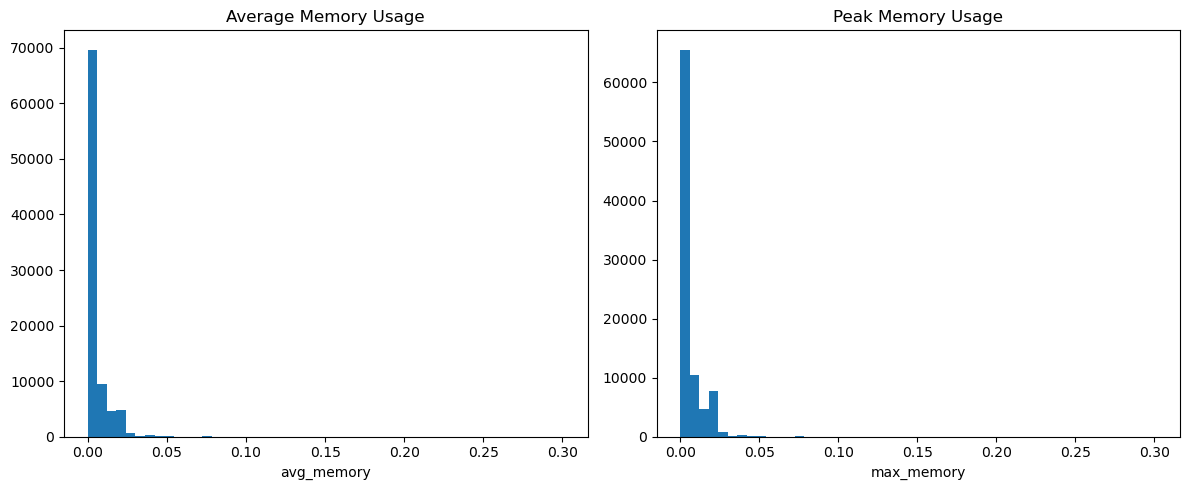

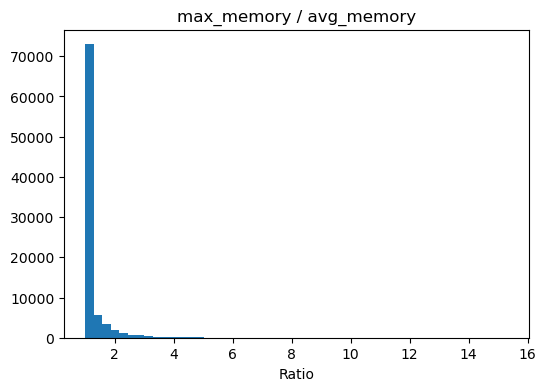

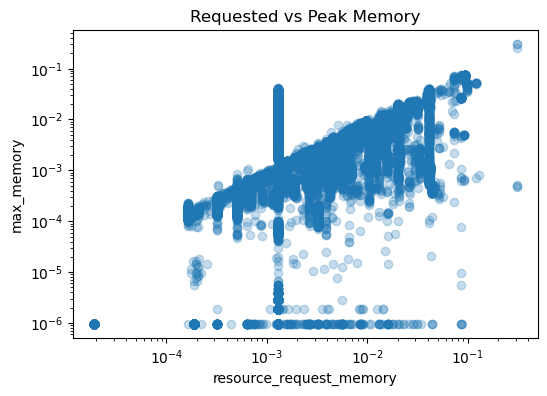

{'avg_memory_mean': 0.004004578049977592,
 'max_memory_mean': 0.004826792897118435,
 'mean_mem_volatility': 1.1967913654853275,
 'median_mem_volatility': 1.0209580838323353,
 'mean_request_to_peak_ratio': 134.1943666107854,
 'median_request_to_peak_ratio': 1.4230769230773217}

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Remove duplicate columns (your df has duplicates)
df_expanded = df_expanded.loc[:, ~df_expanded.columns.duplicated()]

# Select memory related columns
mem_df = df_expanded[['avg_memory', 'max_memory', 'assigned_memory', 'resource_request_memory']].copy()
mem_df = mem_df.dropna()

# Ratios
mem_df['max_to_avg_ratio'] = mem_df['max_memory'] / mem_df['avg_memory'].replace(0, np.nan)
mem_df['request_to_peak_ratio'] = mem_df['resource_request_memory'] / mem_df['max_memory'].replace(0, np.nan)

# 1. Histograms
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(mem_df['avg_memory'], bins=50)
plt.title('Average Memory Usage')
plt.xlabel('avg_memory')

plt.subplot(1,2,2)
plt.hist(mem_df['max_memory'], bins=50)
plt.title('Peak Memory Usage')
plt.xlabel('max_memory')

plt.tight_layout()
plt.show()

# 2. Volatility ratio
plt.figure(figsize=(6,4))
plt.hist(mem_df['max_to_avg_ratio'], bins=50)
plt.title('max_memory / avg_memory')
plt.xlabel('Ratio')
plt.show()

# 3. Requested vs Peak memory
plt.figure(figsize=(6,4))
plt.scatter(mem_df['resource_request_memory'], mem_df['max_memory'], alpha=0.25)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("resource_request_memory")
plt.ylabel("max_memory")
plt.title("Requested vs Peak Memory")
plt.show()

# 4. Summary stats
summary_stats = {
    "avg_memory_mean": mem_df["avg_memory"].mean(),
    "max_memory_mean": mem_df["max_memory"].mean(),
    "mean_mem_volatility": mem_df["max_to_avg_ratio"].mean(),
    "median_mem_volatility": mem_df["max_to_avg_ratio"].median(),
    "mean_request_to_peak_ratio": mem_df["request_to_peak_ratio"].mean(),
    "median_request_to_peak_ratio": mem_df["request_to_peak_ratio"].median(),
}

summary_stats


Event Frequencies:
 instance_events_type
7     53954
4     18984
3     16183
10      512
6       148
5       124
0        93
2         1
8         1
Name: count, dtype: int64

Failures by Scheduling Class:
 scheduling_class
0      359
1     3478
2    19293
3    12037
Name: instance_events_type, dtype: int64

Failure Rate by Memory Request Bin:
 mem_bin
(-0.001, 0.000318]    0.468645
(0.000318, 0.0013]    0.242183
(0.0013, 0.00457]     0.458042
(0.00457, 0.0117]     0.460023
(0.0117, 0.306]       0.597848
Name: instance_events_type, dtype: float64


/var/folders/cr/rc66z7ts2qn1q0_v4n58rbt40000gn/T/ipykernel_1358/2978220274.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fail_rate_by_mem = df_mem.groupby('mem_bin')['instance_events_type'].apply(


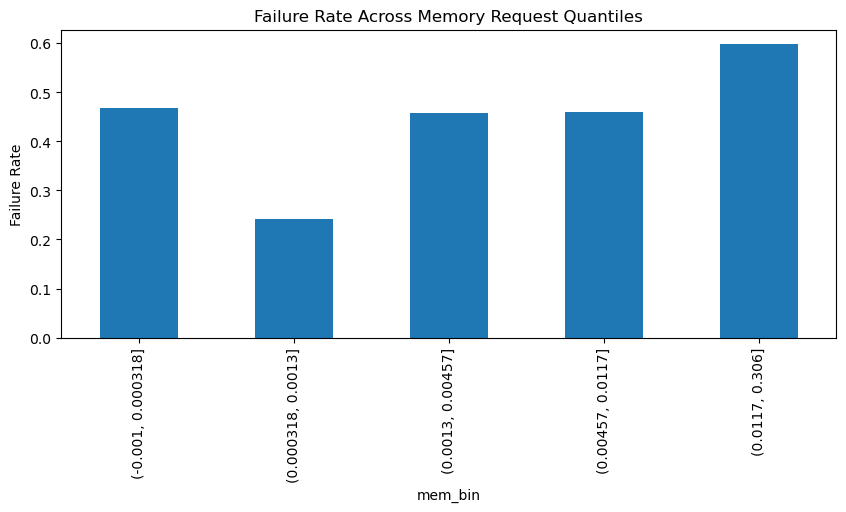

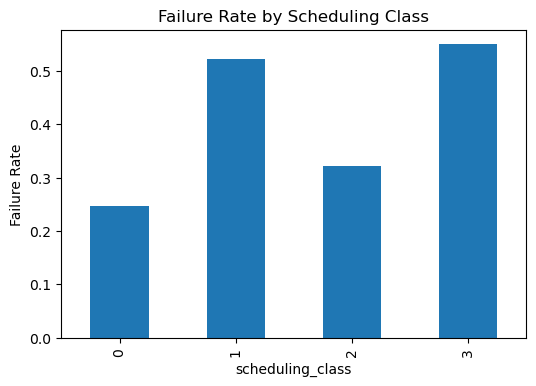

In [120]:
# 1. Event frequencies
event_counts = df_expanded['instance_events_type'].value_counts()
print("Event Frequencies:\n", event_counts)

# 2. Failures/Evictions (3=eviction, 4=failure)
failure_df = df_expanded[df_expanded['instance_events_type'].isin([3, 4])]

fail_by_sched = failure_df.groupby('scheduling_class')['instance_events_type'].count()
print("\nFailures by Scheduling Class:\n", fail_by_sched)

# 3. Failure rate across memory-request deciles
df_mem = df_expanded.dropna(subset=['resource_request_memory']).copy()
df_mem['mem_bin'] = pd.qcut(df_mem['resource_request_memory'], q=10, duplicates="drop")

fail_rate_by_mem = df_mem.groupby('mem_bin')['instance_events_type'].apply(
    lambda s: s.isin([3,4]).mean()
)

print("\nFailure Rate by Memory Request Bin:\n", fail_rate_by_mem)

# Plot failure vs memory
fail_rate_by_mem.plot(kind='bar', figsize=(10,4),
                      title='Failure Rate Across Memory Request Quantiles')
plt.ylabel('Failure Rate')
plt.show()

# 4. Failure rate per scheduling class
fail_rate_sched = df_expanded.assign(
    fail=df_expanded['instance_events_type'].isin([3,4])
).groupby('scheduling_class')['fail'].mean()

fail_rate_sched.plot(kind='bar', figsize=(6,4),
                     title='Failure Rate by Scheduling Class')
plt.ylabel('Failure Rate')
plt.show()
